In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import densenet121, resnet18
import torch.nn as nn
import torch.optim as optim

selected_folders = 'images_001|images_002|images_003|images_004|images_005'

# Load and filter data
data = pd.read_csv('./data/Data_Entry_2017.csv')
data = data[data['Patient Age'] < 100]  # Removing invalid ages
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join('.', 'data', 'images*', '*', '*.png'))}
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].astype(int)
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
mask = data['path'].str.contains(selected_folders)
data = data[mask]
# print(data['path'])


# Process labels
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if x]
for label in all_labels:
    if len(label) > 1:  # Avoid empty labels
        data[label] = data['Finding Labels'].map(lambda findings: 1.0 if label in findings else 0)

# Filter labels to keep
MIN_CASES = 1000
all_labels = [label for label in all_labels if data[label].sum() > MIN_CASES]
data['disease_vec'] = data[all_labels].values.tolist()

# Print information
print(f"Clean Labels ({len(all_labels)}): {[(label, int(data[label].sum())) for label in all_labels]}")
print('Scans found:', len(data_image_paths), ', Total Headers:', data.shape[0])

Clean Labels (9): [('Atelectasis', 4378), ('Cardiomegaly', 1206), ('Consolidation', 1707), ('Effusion', 4584), ('Infiltration', 6716), ('Mass', 1855), ('Nodule', 2235), ('Pleural_Thickening', 1312), ('Pneumothorax', 1879)]
Scans found: 112120 , Total Headers: 44998


In [2]:
data[['Image Index', 'path']]

,Image Index,path
0,00000001_000.png,./data/images_001/images/00000001_000.png
1,00000001_001.png,./data/images_001/images/00000001_001.png
2,00000001_002.png,./data/images_001/images/00000001_002.png
3,00000002_000.png,./data/images_001/images/00000002_000.png
4,00000003_000.png,./data/images_001/images/00000003_000.png
...,...,...
44994,00011558_003.png,./data/images_005/images/00011558_003.png
44995,00011558_004.png,./data/images_005/images/00011558_004.png
44996,00011558_005.png,./data/images_005/images/00011558_005.png
44997,00011558_006.png,./data/images_005/images/00011558_006.png


In [3]:
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_paths, labels, transform=None):
        self.dataframe = dataframe
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['path']
        image = Image.open(image_path).convert('RGB')
        label = torch.tensor(self.dataframe.iloc[idx][self.labels].astype(float).values)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.20, random_state=2018, stratify=data['Finding Labels'].str[:4])
train_df, valid_df = train_test_split(train_df, test_size=0.10, random_state=2018, stratify=train_df['Finding Labels'].str[:4])

# Create DataLoaders
train_dataset = ChestXrayDataset(train_df, data_image_paths, all_labels, transform=transform)
valid_dataset = ChestXrayDataset(valid_df, data_image_paths, all_labels, transform=transform)
test_dataset = ChestXrayDataset(test_df, data_image_paths, all_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [13]:
# train_df.to_csv('train_df.csv', index = False)
# valid_df.to_csv('valid_df.csv', index = False)
# test_df.to_csv('test_df.csv', index = False)

In [54]:
from torchvision import models
class ViT(nn.Module):
    def __init__(self, num_classes):
        super(ViT, self).__init__()
        self.model = models.vit_b_32(pretrained = False)
        self.model.heads.head = nn.Linear(768, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = self.model(x)
        return self.sigmoid(features)

class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.model = models.resnet18(pretrained = False)
        self.model.fc = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = self.model(x)
        return self.sigmoid(features)

class CNNViT(nn.Module):
    def __init__(self, num_classes):
        super(CNNViT, self).__init__()
        self.model1 = models.resnet18(pretrained = False)
        self.model1.fc = nn.Linear(512, 512)
        self.model2 = models.vit_b_32(pretrained = False)
        self.model2.heads.head = nn.Linear(768, 512)
#         self.classifier = nn.Sequential(nn.Linear(1024, 512), 
#                                         nn.ReLU(),
#                                         nn.Linear(512, num_classes),
#                                         nn.Sigmoid())
        self.classifier = nn.Sequential(nn.Linear(512, num_classes),
                                        nn.Sigmoid())
        
        self.attn = nn.MultiheadAttention(512, 1)
        self.norm = nn.LayerNorm(512)
        

    def forward(self, x):
#         print(x.shape)
#         features = self.features(x)
        features1 = self.model1(x)
        features2 = self.model1(x)
#         features = torch.concat([features1, features2], dim=1)
#         features, _ = self.attn(features2, features1, features1)
        features = self.norm(features1 + features2)
        out = self.classifier(features)
        return out

model = ResNet(len(all_labels))
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.BCELoss()
print(model)

ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

/home/sakib/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sakib/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [92]:
from tqdm import tqdm
# Training and Validation Loop
def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0.0
        total_correct = 0
        total_samples = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
#             print(images.shape)
            outputs = model(images)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            # Count correct predictions
            correct = (predicted == labels).all(dim=1).sum().item()
            total_correct += correct

            # Increment total number of samples
            total_samples += labels.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        train_accuracy = total_correct / total_samples * 100
        
        # Validation Phase
        model.eval()
        total_valid_loss = 0.0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs.float(), labels.float())
                total_valid_loss += loss.item()
                
                predicted = (outputs > 0.5).float()
                # Count correct predictions
                correct = (predicted == labels).all(dim=1).sum().item()
                total_correct += correct

                # Increment total number of samples
                total_samples += labels.size(0)

        avg_valid_loss = total_valid_loss / len(valid_loader)
        val_loss.append(avg_valid_loss)
        val_accuracy = total_correct / total_samples * 100
        
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_valid_loss:.4f}')
        print(train_accuracy, val_accuracy)
        
    return train_loss, val_loss

# Continue with model training
train_and_validate(model.cuda(), train_loader, valid_loader, criterion, optimizer, num_epochs=5)

  0%|▏                                          | 2/507 [00:01<07:32,  1.12it/s]


KeyboardInterrupt: 

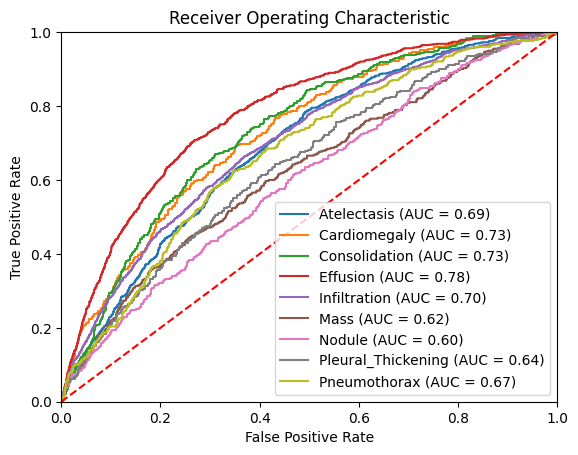

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to compute the ROC AUC score
def compute_roc_auc(model, data_loader, num_classes):
    model.eval()
    y_true = torch.FloatTensor().cuda()
    y_pred = torch.FloatTensor().cuda()
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            y_true = torch.cat((y_true, labels), 0)
            y_pred = torch.cat((y_pred, outputs), 0)

    roc_auc_dict = {}
    for i, label in enumerate(all_labels):
        fpr, tpr, _ = roc_curve(y_true.cpu()[:, i], y_pred.cpu()[:, i])
        roc_auc_dict[label] = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
    
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return roc_auc_dict

# Compute and plot ROC AUC
roc_auc_scores = compute_roc_auc(model, test_loader, len(all_labels))

In [73]:
print(roc_auc_scores)

{'Atelectasis': 0.6907429274725274, 'Cardiomegaly': 0.7286546463245493, 'Consolidation': 0.73439747363746, 'Effusion': 0.7816913427227411, 'Infiltration': 0.6991681835324142, 'Mass': 0.623308248870436, 'Nodule': 0.5999557502135489, 'Pleural_Thickening': 0.6387877997868261, 'Pneumothorax': 0.6717927499358721}


In [74]:
sum(list(roc_auc_scores.values()))/9.0

0.6853887913884862

In [ ]:
# Visualization of Predictions
def visualize_predictions(model, data_loader, num_images=4):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    outputs = outputs > 0.5  # Threshold predictions

    fig, axs = plt.subplots(1, num_images, figsize=(15, 10))
    for i in range(num_images):
        axs[i].imshow(images[i].cpu().permute(1, 2, 0))
        axs[i].axis('off')
        disease_labels = ', '.join([all_labels[j] for j in range(outputs.shape[1]) if outputs[i, j] == 1])
        axs[i].set_title(disease_labels)

    plt.show()

# Call visualization function
visualize_predictions(model, test_loader, num_images=4)

In [93]:
# import torch
# import numpy as np

# def save_samples_from_loader(dataloader, filename_prefix, num_batches=1):
#     images_list = []
#     labels_list = []
    
#     for i, (images, labels) in enumerate(tqdm(dataloader)):
#         # Assuming images and labels are torch.Tensors
#         images_list.append(images.numpy())  # Convert PyTorch tensor to numpy array
#         labels_list.append(labels.numpy())
# #         print(images.shape)
# #         if i >= num_batches - 1:
# #             break

#     # Concatenate all collected batches
#     images_array = np.concatenate(images_list, axis=0)
#     labels_array = np.concatenate(labels_list, axis=0)
#     print(images_array.shape)
#     print(labels_array.shape)

#     # Save to .npy files
#     np.save(f'{filename_prefix}_images.npy', images_array)
#     np.save(f'{filename_prefix}_labels.npy', labels_array)

# # Use the function to save samples from each DataLoader
# save_samples_from_loader(train_loader, './npy/train_sample', num_batches=1)  # Save 1 batch of 64 samples
# save_samples_from_loader(valid_loader, './npy/valid_sample', num_batches=1)  # Save 1 batch of 64 samples
# save_samples_from_loader(test_loader, './npy/test_sample', num_batches=10)  # Save 10 batches of 1 sample each

In [94]:
# !pip install timm

## Gated Features Probing (W/T Attention)

In [80]:
import torch
import torch.nn as nn
from torchvision import models
import timm 

class ViTFeatureExtractor(nn.Module):
    def __init__(self, model_name='vit_base_patch32_224', pretrained=True):
        super(ViTFeatureExtractor, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.model.head = nn.Identity()  # Removing the classification head

    def forward(self, x):
        features = self.model.forward_features(x)  # Get features before the head
        if features.dim() == 3:  # If features are in (B, C, H, W) format
            features = features.flatten(start_dim=1)  # Flatten from (B, C, H, W) to (B, C*H*W)
        return features

class EnhancedCNNViT_AFF(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNNViT_AFF, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Use as a feature extractor

        self.vit = ViTFeatureExtractor(pretrained=True)

        # Correct the combined feature dimension
        combined_feature_dim = 512 + 38400  # 512 from ResNet and 38400 from ViT

        self.classifier = nn.Sequential(
            nn.Linear(combined_feature_dim, 512),  # Adjust this to the correct combined dimension
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Assuming multi-label classification
        )

    def forward(self, x):
        res_features = self.resnet(x)  # (B, 512)
        vit_features = self.vit(x)  # (B, 38400), assuming 50*768=38400
        combined_features = torch.cat((res_features, vit_features), dim=1)  # Concatenate features
        output = self.classifier(combined_features)
        return output

# Example usage
model = EnhancedCNNViT_AFF(num_classes=len(all_labels))  # Assuming 10 classes for the task
print(model)  # Printing model summary to understand its structure

# Optional: Summary with input size specification (requires torchsummary)
from torchsummary import torchsummary
torchsummary.summary(model, input_size=(3, 224, 224), device='cpu')  # or 'cuda' if using GPU

EnhancedCNNViT_AFF(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

ModuleNotFoundError: No module named 'torchsummary'

## Iterative Neuron Probing (W/O Attention)

In [85]:
import torch
import torch.nn as nn
from torchvision import models
import timm

class NeuronProber(nn.Module):
    def __init__(self, num_features, num_classes):
        super(NeuronProber, self).__init__()
        self.num_features = num_features
        self.num_classes = num_classes
        # Initialize probe weights that adapt each feature for each class
        self.probe_weights = nn.Parameter(torch.rand(num_classes, num_features))

    def forward(self, features):
        # Normalize probe weights to range [0, 1] using sigmoid
        normalized_weights = torch.sigmoid(self.probe_weights)

        # Adjust features based on class-specific probe weights
        class_specific_features = features.unsqueeze(1) * normalized_weights.unsqueeze(0)

        # Aggregate features: one simple approach is to take the mean of adjusted features
        aggregated_features = class_specific_features.mean(dim=1)
#         print("NeuronProber Output Shape:", aggregated_features.shape)  # Should be [64, num_features]

        return aggregated_features
class EnhancedCNNViT_NP(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNNViT_NP, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Use the feature extractor part only

        self.vit = models.vit_b_32(pretrained=True)
        self.vit.heads.head = nn.Identity()  # Use the feature extractor part only

        self.feature_dim = 512 + 768  # Assuming 512 from ResNet and 768 from ViT
        self.prober = NeuronProber(self.feature_dim, num_classes)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        resnet_features = self.resnet(x)
        vit_features = self.vit(x)
        
        # Concatenate features from both models
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        
        # Probe and enhance features
        enhanced_features = self.prober(combined_features)
        
        # Final classification
        output = self.classifier(enhanced_features)
        return output

model = EnhancedCNNViT_NP(num_classes=len(all_labels))

/home/sakib/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sakib/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sakib/anaconda3/envs/dl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=

### Train/Validation Loop

In [86]:
import gc
# Training and Validation Loop
def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20):
    model.cuda()
    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_valid_loss = 0, 0
        total_train_correct, total_valid_correct = 0, 0
        total_train_samples, total_valid_samples = 0, 0

        # Training
        for images, labels in tqdm(train_loader):
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
#             print(images.shape)
            outputs = model(images)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            # Calculating accuracy
            predicted = outputs.round()
            total_train_correct += (predicted == labels).all(dim=1).sum().item()
            total_train_samples += labels.size(0)

        # Validation
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs.float(), labels.float())
                total_valid_loss += loss.item()

                # Calculating accuracy
                predicted = outputs.round()
                total_valid_correct += (predicted == labels).all(dim=1).sum().item()
                total_valid_samples += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_valid_loss = total_valid_loss / len(valid_loader)
        train_accuracy = (total_train_correct / total_train_samples) * 100
        valid_accuracy = (total_valid_correct / total_valid_samples) * 100

        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {valid_accuracy:.2f}%')

# Free up memory
gc.collect()
torch.cuda.empty_cache()

model = EnhancedCNNViT_NP(num_classes=len(all_labels))
# Call training/validation function
train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=5)

# ROC AUC Calculation
compute_roc_auc(model, test_loader, len(all_labels))

100%|███████████████████████████████████████████| 57/57 [00:41<00:00,  1.36it/s]


Epoch [1/5]: Train Loss: 1.2698, Validation Loss: 1.2675
Train Accuracy: 0.28%, Validation Accuracy: 0.36%


100%|███████████████████████████████████████████| 57/57 [00:41<00:00,  1.37it/s]


Epoch [2/5]: Train Loss: 1.2679, Validation Loss: 1.2673
Train Accuracy: 0.31%, Validation Accuracy: 0.36%


100%|███████████████████████████████████████████| 57/57 [00:41<00:00,  1.36it/s]


Epoch [3/5]: Train Loss: 1.2686, Validation Loss: 1.2674
Train Accuracy: 0.31%, Validation Accuracy: 0.31%


  1%|▍                                          | 5/507 [00:04<07:13,  1.16it/s]


KeyboardInterrupt: 